## Pacotes 

In [1]:
from LightPipes import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy

## Definições 

In [2]:
def Lambda(M,N,sigma,delta):
  a = 1/(4*sigma**2) # [L]^-2
  b = 1/(2*delta**2) # [L]^-2
  c = 2*np.sqrt( a**2 + 2*a*b )
  L = ( np.pi/(a + b + c/2) )*( (a + b - c/2)/( a + b + c/2 ) )**( abs(M)/2 + N )
  return L

## Parâmeteros

In [5]:
### Parâmeteros 
lambd = 780*nm;                           
w0    = .15*mm; 
sigma = w0        # Coerente                 
delta = .15*mm; 
truncamento = 0.015

n  = 2**7;   
dx = 10*um;                              
x  = np.arange(-n/2,n/2,1)*dx
[xx,yy] = np.meshgrid(x,x);   

Linc = 300
Lcoh = 20

In [6]:
#----   GSM Pseudo Coerente   ---------------------------------
p_v = 1/(  np.pi*delta )
aux2 = np.exp(1j*np.zeros((n,n,Linc)))
aux3 = np.zeros((n,n,Linc))

for ii in range(0,Linc):
  u = np.zeros_like(xx);
# Coherent sum
  for jj in range(0,Lcoh):
    for kk in range(0,Lcoh):
      v_x = (jj*2*p_v/(Lcoh-1)) - p_v; 
      v_y = (kk*2*p_v/(Lcoh-1)) - p_v; 

      Hologram = ( np.sqrt( 2*np.pi )*delta  )*(
                  np.exp( - ( v_x**2 + v_y**2 )*( np.pi*delta )**2 
                          - ( ( xx**2 + yy**2 )/(2*w0 )**2 )
                          + 2j*np.pi*( xx*v_x + yy*v_y )
                          + 2j*np.pi*( np.random.random(1) )
                         ))
      u = u + Hologram  
  # normalization
  u = u/u.max()
    
  aux2[:,:,ii] = u
  aux3[:,:,ii] = abs(u)**2

  
#----   GSM Coerente   ---------------------------------

Numero_de_Soma_Inc = 0
L = 50; P = 50
for j in range(-L,L+1):
  for jj in range(P+1):
    cutoff  = Lambda(j,jj,sigma,delta)/Lambda(0,0,sigma,delta)
    if (cutoff >= truncamento):
      Numero_de_Soma_Inc +=1
print("Quantidade de modos =",Numero_de_Soma_Inc)
print("Quantidade de P-modos =",Linc)

#Gerando os campos para a soma incoerente
a = 1/(4*sigma**2) # [L]^-2
b = 1/(2*delta**2) # [L]^-2
c = 2*np.sqrt( a**2 + 2*a*b ) 
w = np.sqrt( 2/c )

S =  np.exp( 1j*np.zeros((n,n,Numero_de_Soma_Inc))) # Campo 
aux4 = np.zeros( (n,n,Numero_de_Soma_Inc) )           # Intensidade 

i = 0
for j in range(-L,L+1):
  for jj in range(P+1):
    cutoff  = Lambda(j,jj,sigma,delta)/Lambda(0,0,sigma,delta)
    if (cutoff >= truncamento):
      r    = np.sqrt(xx**2+yy**2)                                                 
      C    = np.sqrt(2*np.math.factorial(jj)/(np.pi*np.math.factorial(jj+abs(j))))
      PL   = scipy.special.assoc_laguerre(2*r**2/w**2,jj,abs(j))
      Fase = np.exp(- 1j*j*np.arctan2(yy,xx) )

      LG   = C*1/w*(r*np.sqrt(2)/w)**abs(j)*PL*np.exp(-r**2/w**2)*Fase

      S[:,:,i] = np.sqrt(Lambda(j,jj,sigma,delta))*LG
      aux4[:,:,i] = abs( ( np.sqrt(Lambda(j,jj,sigma,delta))*LG)*( np.sqrt(Lambda(j,jj,sigma,delta))*np.conj(LG) ) )
      i += 1

Quantidade de modos = 15
Quantidade de P-modos = 300


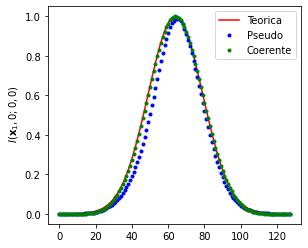

In [50]:
A = np.sum( aux3 ,2)
A = A/A.max()

A2 = np.sum( aux4 ,2)
A2 = A2/A2.max()

Int_T =  np.exp( - x**2/(2*w0**2 )  )

#$$$$$$$$$$$$$$$$$
plt.subplots(figsize=(10,4))
plt.subplot(1,2,1)
plt.ylabel(" $I(\mathbf{x}_1,0;0,0)$")

plt.plot(Int_T,'r',label='Teorica')
plt.plot( A[:,64],'b.',label='Pseudo')
plt.plot(A2[:,64],'g.',label='Coerente')

plt.legend(loc=1)
#plt.axis("off")
plt.show()

### DOC individual para cada metodo 

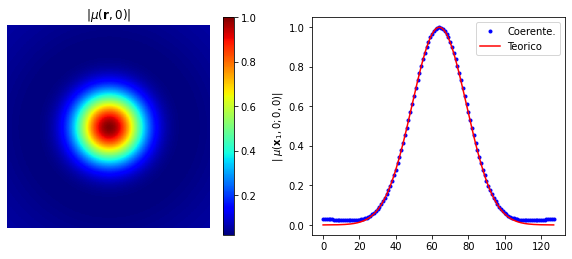

In [55]:
ref = [0,0]                        
index = np.where((xx==ref[0])*(yy==ref[1])==True)        

mu = np.zeros_like(S[:,:,1])
intMap = np.sum(abs(S)**2,2) 

for ii in range(0,n):
    for jj in range(0,n):
      mu[ii,jj] = np.sum( np.conj(S[ii,jj,:])*S[index[0],index[1],:]    )/np.sqrt(intMap[ii,jj]*intMap[index[0],index[1]])

img = abs(mu) 
img = img/img.max()

BB = np.exp(-x**2/(2*delta**2) )

fig, ax = plt.subplots(figsize=(10,4))

plt.subplot(1,2,1)
#plt.title("a)", loc = 'left')
plt.imshow(img,cmap = "jet")
plt.title('|$\mu(\mathbf{r},0)$|')
plt.colorbar()
plt.axis("off")

plt.subplot(1,2,2)
#plt.title("b)", loc = 'left')
plt.ylabel("| $\mu(\mathbf{x}_1,0;0,0)$|")
plt.plot(img[:,64],"b.", label='Coerente.')
plt.plot(BB,"r",label='Teorico')
#plt.axis("off")
plt.legend(loc=1)
plt.show()


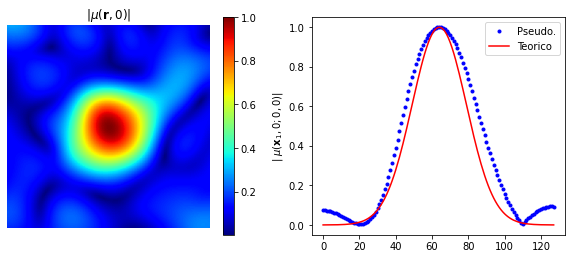

In [54]:
ref = [0,0]                        
index = np.where((xx==ref[0])*(yy==ref[1])==True)        

mu = np.zeros_like(aux2[:,:,1])
intMap = np.sum(aux3,2) # somando as intensidensia

for ii in range(0,n):
    for jj in range(0,n):
      mu[ii,jj] = np.sum( np.conj(aux2[ii,jj,:])*aux2[index[0],index[1],:] )/np.sqrt(intMap[ii,jj]*intMap[index[0],index[1]])

img = abs(mu) 
img = img/img.max()

BB = np.exp(-x**2/(2*delta**2) )

fig, ax = plt.subplots(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img,cmap = "jet")
plt.title('|$\mu(\mathbf{r},0)$|')
plt.colorbar()
plt.axis("off")

plt.subplot(1,2,2)
plt.ylabel("| $\mu(\mathbf{x}_1,0;0,0)$|")
plt.plot(img[:,64],"b.", label='Pseudo.')
plt.plot(BB,"r",label='Teorico')
#plt.axis("off")
plt.legend(loc=1)
plt.show()


## DOC de ambos 

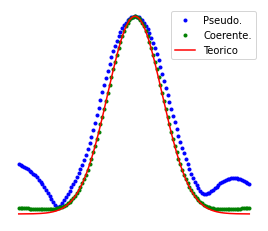

In [7]:
#__________________________METODO COERENTE ______________________
ref = [0,0]                        
index = np.where((xx==ref[0])*(yy==ref[1])==True)        
mu = np.zeros_like(S[:,:,1])
intMap = np.sum(abs(S)**2,2) 
for ii in range(0,n):
    for jj in range(0,n):
      mu[ii,jj] = np.sum( np.conj(S[ii,jj,:])*S[index[0],index[1],:]    )/np.sqrt(intMap[ii,jj]*intMap[index[0],index[1]])
img = abs(mu) 
img = img/img.max()
BB = np.exp(-x**2/(2*delta**2) )
#__________________________METODO PSEUDO ______________________
  
intMap2 = np.sum(aux3,2) # somando as intensidensia
for ii in range(0,n):
    for jj in range(0,n):
      mu[ii,jj] = np.sum( np.conj(aux2[ii,jj,:])*aux2[index[0],index[1],:] )/np.sqrt(intMap2[ii,jj]*intMap2[index[0],index[1]])
img2 = abs(mu) 
img2 = img2/img2.max()
#___________________#___________________#___________________
plt.subplots(figsize=(10,4))
plt.subplot(1,2,2)
plt.ylabel("| $\mu(\mathbf{x}_1,0;0,0)$|")
plt.plot(img2[:,64],"b.", label='Pseudo.')
plt.plot( img[:,64],"g.", label='Coerente.')
plt.plot(BB,"r",label='Teorico')
plt.legend(loc=1)
plt.axis("off")
plt.show()